In [1]:
using Revise, LazySets, Plots, ReachabilityAnalysis

┌ Info: Precompiling LazySets [b4f0291d-fe17-52bc-9479-3d1a343d9043]
└ @ Base loading.jl:1260
┌ Info: Precompiling ReachabilityAnalysis [1e97bd63-91d1-579d-8e8d-501d2b57c93f]
└ @ Base loading.jl:1260
┌ Warning: Replacing docs for `LazySets.Hyperplane :: Union{Tuple{Operation}, Tuple{Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `LazySets.HalfSpace :: Union{Tuple{Operation}, Tuple{Operation,Any}}` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{Array{TaylorModels.TaylorModel1{T,S},1},Type{#s50} where #s50<:Zonotope}} where S where T` in module `LazySets.Approximations`
└ @ Base.Docs docs/Docs.jl:229
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{N}, Tuple{Array{TaylorModels.TaylorModelN{N,T,S},1},Type{#s48} where #s48<:Zonotope}} where S where T where N` in module `Laz

In [39]:
using LazySets: center, _above, normalize
function BOUND_INTERSECT_2D(Z::AbstractZonotope, L::Line2D)
    c = center(Z)
    P = copy(c)
    gens = genmat(Z)
    r = ngens(Z)
    for gi in [gens[:, x] for x in 1:r]
        if(gi[2] > 0 || (gi[2] == 0 && gi[1] > 0))
            gi = -gi
        end
        P = P - gi
    end
    # SORT?
    j = 1
    while isempty(intersection(Line2D(P, P.+2gens[:, j]), L))
        P = P + gens[:, j]
        j += 1
    end
    vec = intersection(Line2D(P, P.+2gens[:, j]), L)
    return vec
end

BOUND_INTERSECT_2D (generic function with 1 method)

In [40]:
Z = rand(Zonotope, num_generators=20)
L = Line2D([0, 0.], [1, 3.])

Line2D{Float64,Array{Float64,1}}([-3.0, 1.0], 0.0)

In [41]:
i = BOUND_INTERSECT_2D(Z, L)

Singleton{Float64,Array{Float64,1}}([8.207173520357923, 24.621520561073773])

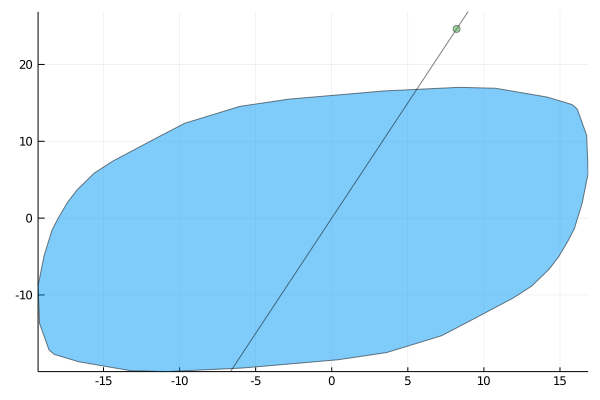

In [42]:
plot(Z)
plot!(L)
plot!(i)

In [21]:
function intersec(Z::AbstractZonotope{N}, L::Line2D) where {N}
    c = center(Z)
    P = copy(c)
    gens = genmat(Z)
    r = ngens(Z)
    for gi in [gens[:, x] for x in 1:r]
        if(gi[2] > 0 || (gi[2] == 0 && gi[1] > 0))
            gi = -gi
        end
        P = P - gi
    end
    G = Vector{Vector{N}}(undef, 0)
    if(P[1] < L.b)
        for gi in [gens[:, x] for x in 1:r]
            if(gi[1] >= 0)
                push!(G, gi)
            end
        end
    else
        for gi in [gens[:, x] for x in 1:r]
            if(gi[1] <= 0)
                push!(G, gi)
            end
        end
    end
    s = sum(G)
    
    while length(G) > 1
        G1 = Vector{Vector{N}}(undef, 0)
        G2 = copy(G1)
        for gi in G
            if _above(gi, s, [0, 1])
                push!(G1, gi)
            else
                push!(G2, gi)
            end
        end
        s1 = 2 * sum(G1)
        if !isempty(intersection(Line2D(P, P.+s1), L))
            G = G1
            s = s1
        else
            G = G2
            s = s - s1
            P = P + s1
        end
        break
    end
    vec = intersection(Line2D(P, P.+s), L)
end

intersec (generic function with 1 method)

In [27]:
i2 = intersec(Z, L)

Singleton{Float64,Array{Float64,1}}([-46.886560712129, -46.886560712129])

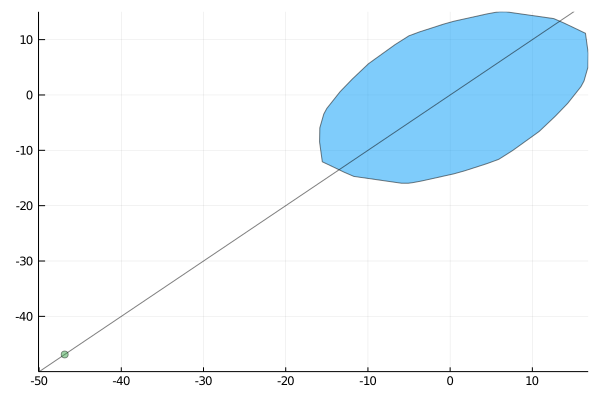

In [28]:
plot(Z)
plot!(L)
plot!(i2)